# GPU Check

In [ ]:
import GPUtil
GPUs = GPUtil.getGPUs()
for gpu in GPUs:
  print(gpu.name, gpu.memoryTotal)

# Imports

In [2]:
# from search_eval.utils.common_utils import *
from search_eval.eval_no_search_SGLD import Eval_SGLD, SingleImageDataset

from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from search_space.unet.unet import UNet

import numpy as np
import torch
torch.cuda.empty_cache()

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))


CUDA available: True


# Execute

Using cache found in /home/joe/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




----------------------------------
Experiment Configuration:
	Total Iterations: 1200
	Burnin Iterations: 200
	Learning Rate: 0.1
	Image Resolution: 64
	Plotting every 100 iterations
----------------------------------


[2023-09-11 07:42:52] WARNING: Validation dataloaders are missing.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model_cls | UNet    | 31.0 M
1 | criteria  | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the l

Training: 0it [00:00, ?it/s]

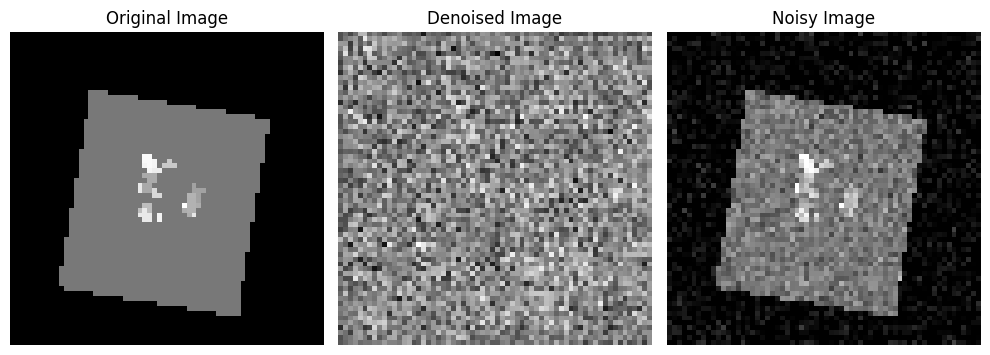

[2023-09-11 07:42:56] Intermediate result: {"iteration": 0, "loss": 0.23887, "psnr_noisy": 6.21841, "psnr_gt": 5.83087}  (Index 0)


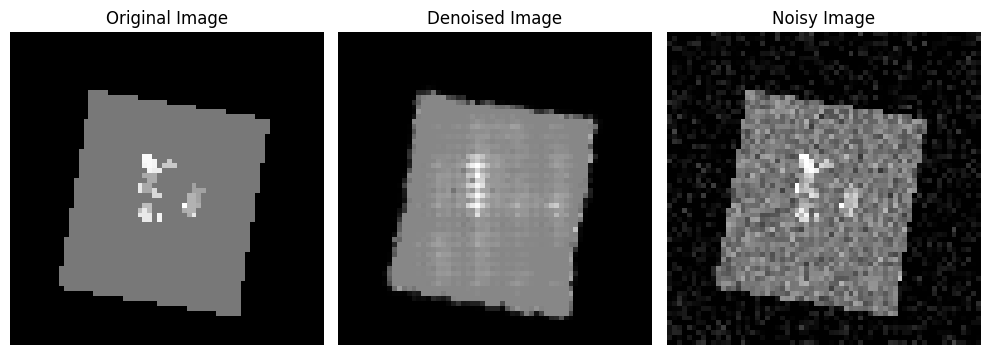

[2023-09-11 07:46:05] Intermediate result: {"iteration": 100, "loss": 0.00742, "psnr_noisy": 21.29657, "psnr_gt": 25.48992}  (Index 1)


In [3]:
# INPUTS
total_iterations = 1200 # optimal 1400
show_every = 100 # 200
report_every = 25 # 25
burnin_iter = 200 # 200
lr = 0.1 #  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)

# model = UNet(in_channels=1, out_channels=1, init_features=64, depth=4)
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)

img_id = np.random.randint(0, 50)
resolution = 64
noise_type = 'gaussian'
noise_level = '0.09'
phantom =       np.load(f'/home/joe/nas-for-dip/phantoms/ground_truth/{resolution}/{img_id}.npy')
phantom_noisy = np.load(f'/home/joe/nas-for-dip/phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{img_id}.npy')

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tImage Config')
print(f'\t\tImage ID: {img_id}')
print(f'\t\tImage Resolution: {resolution}')
print(f'\t\tNoise Type: {noise_type}')
print(f'\t\tNoise Level: {noise_level}\n')

print(f'\tModel Config')
print(f'\t\tModel: {model}\n')

print(f'\tTraining Config')
print(f'\t\tTotal Iterations: {total_iterations}')
print(f'\t\tBurnin Iterations: {burnin_iter}')
print(f'\t\tLearning Rate: {lr}')
print(f'\t\tImage Resolution: {resolution}')
print(f'\t\tPlotting every {show_every} iterations\n')
print(f"----------------------------------\n\n")

# Create the lightning module
module = Eval_SGLD(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,
                lr=lr, 
                burnin_iter=burnin_iter,
                model=model, # model defaults to U-net 
                show_every=show_every
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)